In [1]:
import sys 
sys.path.append('../')

import torch
import matplotlib.pyplot as plt 
from einops import repeat

from src.green_net import GreenNet2D
from src.dd_gmg import DD_GMG2D
from src.model import MLP
from src.utils import rl2_error, matrl2_error
torch.set_printoptions(linewidth=150)

In [2]:
def DiskPoisson(pts):
    x1 = pts[...,0]
    y1 = pts[...,1]
    x2 = pts[...,2]
    y2 = pts[...,3]

    mask = ((x1**2+y1**2) < 1) & ((x2**2+y2**2) < 1)

    k = 1/(4*torch.pi) * torch.log(
        ((x1 - x2)**2 + (y1-y2)**2) / \
        ((x1*y2-x2*y1)**2 + (x1*x2+y1*y2-1)**2))
    k = torch.nan_to_num(k, neginf=1) * mask

    return k

In [3]:
def DiskInvdist(pts):
    x1 = pts[...,0]
    y1 = pts[...,1]
    x2 = pts[...,2]
    y2 = pts[...,3]

    mask = ((x1**2+y1**2) < 1) & ((x2**2+y2**2) < 1)

    k = ((x1 - x2)**2 + (y1-y2)**2) ** (-0.5)
    k = torch.nan_to_num(k, posinf=55) * mask

    return k

In [4]:
def ffunc_2D(pts):
    x = pts[:,0]
    y = pts[:,1]
    u = 1 - (x**2+y**2)
    u = torch.nan_to_num(u, posinf=0)
    return u

In [5]:
n = 6
# device = torch.device('cuda:3')
device = torch.device('cpu')
# kernel = MLP([2, 64, 1], nonlinearity='relu').to(device)
# model = GreenNet2D(n=n, kernel=DiskInvdist, device=device)
model = GreenNet2D(n=n, kernel=DiskPoisson, device=device)

# model = GreenNet2D(n=6, kernel=DiskInvdist, device=device, sub_num=5)

In [6]:
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> b n', b=64)

Ground Truth Kernel Function

In [7]:
model.eval_K()
nh = model.grid.nh
K_full = model.K_hh.reshape(nh,nh,nh,nh)

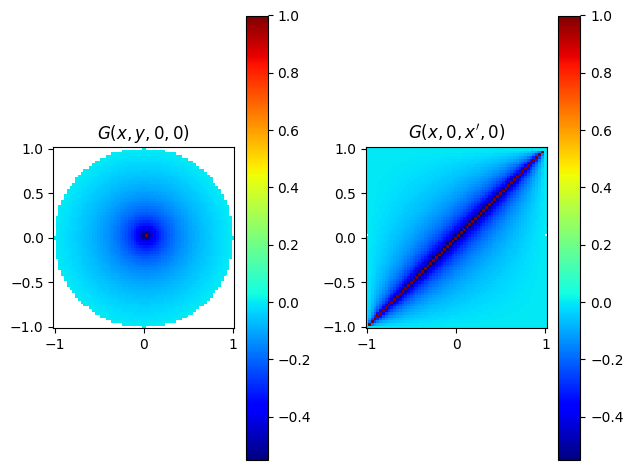

In [8]:
xy = model.grid.x_h.reshape(nh,nh,2).cpu()
mask = (xy[...,0]**2 + xy[...,1]**2) > 1
G_xy00 = K_full[:,:,33,33].cpu()
G_xy00[mask] = torch.nan
G_x0y0 = K_full[:,33,:,33].cpu()
plt.subplot(121)
plt.pcolor(xy[...,0], xy[...,1], G_xy00, cmap='jet')
plt.title('$G(x,y,0,0)$')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.subplot(122)
plt.pcolor(xy[...,0], xy[...,1], G_x0y0, cmap='jet')
plt.title('$G(x,0,x\',0)$')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.tight_layout()

Full Kernel Integral

In [9]:
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> b n', b=64)
U_full = model.full_kint(F)
f = F[0].reshape(nh,nh)
u = U_full[0].reshape(nh,nh)
f[mask] = torch.nan 
u[mask] = torch.nan

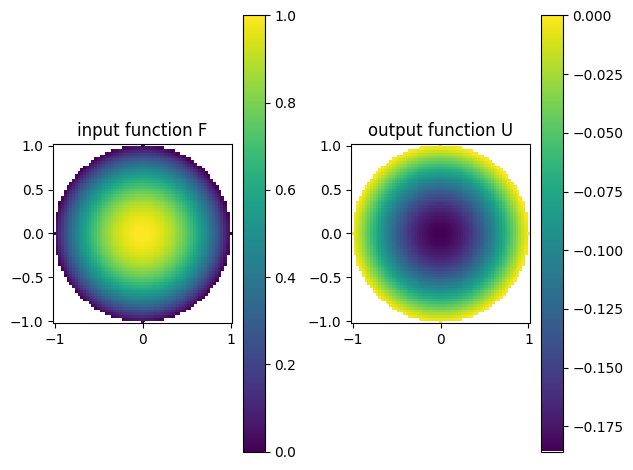

In [10]:
plt.subplot(121)
plt.pcolor(xy[...,0], xy[...,1], f.cpu())
plt.title('input function F')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.subplot(122)
plt.pcolor(xy[...,0], xy[...,1], u.cpu())
plt.title('output function U')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.tight_layout()

# DD Green MG

influence of level coarse : `k`

In [11]:
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> b n', b=64)
# model = GreenNet2D(n, kernel=DiskInvdist, device=device, sub_num=5)
model = GreenNet2D(n, kernel=DiskPoisson, device=device, sub_num=5)

model.eval_K()
U_full = model.full_kint(F)

In [12]:
m = 0
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> b n', b=64)

for k in range(1, 4):
    # dd_gmg = DD_GMG2D(n, m, k, DiskInvdist, device)
    dd_gmg = DD_GMG2D(n, m, k, DiskPoisson, device)
    
    dd_gmg.restrict_ml_f(F)
    dd_gmg.eval_ml_K()
    U_dd = dd_gmg.ml_kint()
    rl2 = rl2_error(U_dd, U_full)
    print('k {:d} - m {:d} - {:.4f}'.format(k, m, rl2))

# coarest pts :  1185921
# correction :  0
ratio 1185921/17850625 = 6.64% 

k 1 - m 0 - 0.0300
# coarest pts :  83521
# correction :  0
ratio 83521/17850625 = 0.47% 

k 2 - m 0 - 0.1390
# coarest pts :  6561
# correction :  0
ratio 6561/17850625 = 0.04% 

k 3 - m 0 - 0.5219


Influence of correction range : `c`

In [14]:
k = 1

for m in [0, 1, 3, 7, 15]:
    dd_gmg = DD_GMG2D(n, m, k, DiskPoisson, device)
    # dd_gmg = DD_GMG2D(n, m, k, DiskInvdist, device)
    dd_gmg.restrict_ml_f(F)
    dd_gmg.eval_ml_K()
    U_dd = dd_gmg.ml_kint()
    rl2 = rl2_error(U_dd, U_full)
    print('k {:d} - m {:d} - {:.4e}'.format(k, m, rl2))

# coarest pts :  1185921
# correction :  0
ratio 1185921/17850625 = 6.64% 

k 1 - m 0 - 2.9951e-02
# coarest pts :  1185921
# correction :  56640
ratio 1242561/17850625 = 6.96% 

k 1 - m 1 - 5.1527e-03
# coarest pts :  1185921
# correction :  507064
ratio 1692985/17850625 = 9.48% 

k 1 - m 3 - 4.8207e-03
# coarest pts :  1185921
# correction :  2447904
ratio 3633825/17850625 = 20.36% 

k 1 - m 7 - 3.6203e-03
# coarest pts :  1185921
# correction :  8392912
ratio 9578833/17850625 = 53.66% 

k 1 - m 15 - 1.1223e-03
